# Labels Profiling
This notebook shows a preliminary exploration of the labels, written with the COCO Keypoint 1.0 format.<br>
In this format we have a number for the class, that is always 0 because we only have foosball tables, 4 numbers for the bounding box (coordinates for the center, width and height) and the variuos keypoints rapresented as *(x, y, v)*, where *x* and *y* are simply the coordinates and *v* is the visibility (2 means visible, 1 means not visible and 0 means not present).

For a foosball table we have 8 keypoints: the first 4 form the upper rectangle of the play area, and the last 4 form the lower rectangle of the play area<br>
**Note** that we technically need just the lower rectangle, but because some of its keypoints are cut out from the image (visibility = 0), we need the upper rectangle, that is **always** present in the image, to be able to build the perspective to obtain the position of the cutted out points.

## Setup
Execute this cell before the other ones.

In [1]:
import pandas as pd
import sys
sys.path.append('..')
from src.config import *

df = pd.read_parquet(LABELS_DATAFRAME_DIRECTORY)

## Centers and Directions Analysis
For center we refer to the center of the upper rectangle, that we can obtain by intersecting the lines that connect the first keypoint to the third, and the second to the fourth.<br>
For direction we refer to the direction given by the center, to the vanishing point obtained by intersecting the lines that connect the first keypoint to the fourth, and the second to the third.

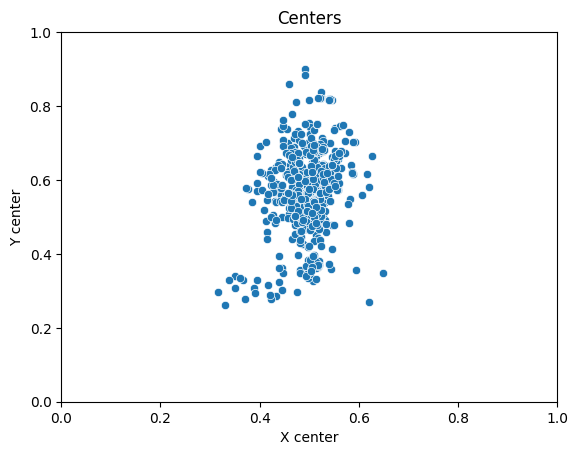

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=df, x=df['center'].str[0], y=df['center'].str[1])
plt.title("Centers")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("X center")
plt.ylabel("Y center")
plt.show()


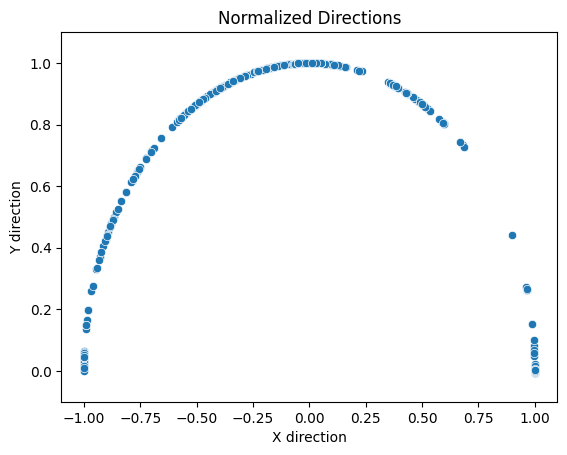

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=df, x=df['direction'].str[0], y=df['direction'].str[1])
plt.title("Normalized Directions")
OFFSET = 0.1
plt.xlim(-(1.0 + OFFSET), 1.0 + OFFSET)
plt.ylim(-(0.0 + OFFSET), 1.0 + OFFSET)
plt.xlabel("X direction")
plt.ylabel("Y direction")
plt.show()

If we convert the direction *(x, y)* to the angle *theta*, we can see which *theta* is the most common.<br>
*theta* is the angle that starts to the right and goes anticlockwise to the left.<br>
(For reference: *(1, 0)* corresponds to 0 degrees, *(1, 1)* corresponds to 90 degrees and (-1, 0) corresponds to 180 degrees)

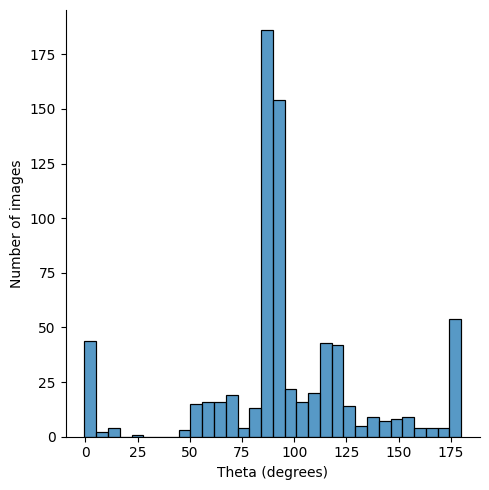

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# let's convert the direction from (x, y) to theta
# where theta is the angle going from 0, that is (1, 0) to 180 that is (-1, 0)

df_aux = df.copy()
theta = [math.degrees(math.atan2(y,x)) for x, y in df_aux["direction"]]
df_aux = df_aux.assign(theta = theta)

sns.displot(df_aux["theta"])
plt.xlabel("Theta (degrees)")
plt.ylabel("Number of images")
plt.show()



## Visibilities Analysis
For the COCO Keypoint 1.0 format, for every keypoint, there is a visibility that is 0 if the keypoint is not present in the image, 1 if it's present, but not visible, and 2 if it's present and visible.

**Note** that the first 4 keypoints never have a visibility of 0, because it's a requirement of the project: we need those 4 keypoints to be able to build the perspective to obtain the 4 other keypoints, if they are cutted out, like we said earlier.

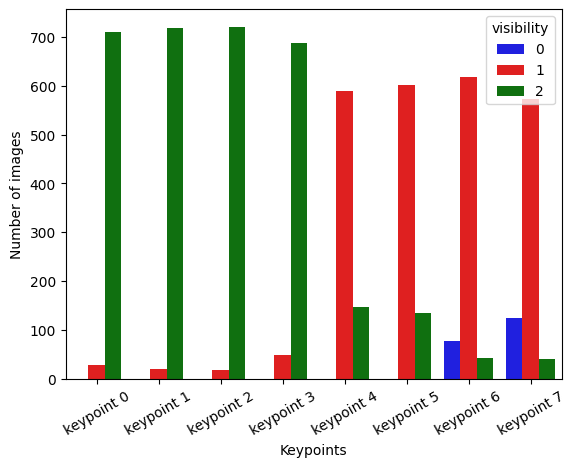

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

df_aux = df.copy()
df_aux = df_aux.explode('visibilities')  # create row for each kepoint
df_aux['keypoint_id'] = df_aux.groupby(level=0).cumcount()  # 0...7
df_aux.rename(columns={'visibilities': 'visibility'}, inplace=True)

KEYPOINT_NAMES = ["keypoint 0","keypoint 1","keypoint 2","keypoint 3","keypoint 4","keypoint 5","keypoint 6","keypoint 7"]
df_aux['keypoint_name'] = df_aux['keypoint_id'].map(dict(enumerate(KEYPOINT_NAMES)))

sns.countplot(data=df_aux, x="keypoint_name", hue="visibility", palette=["blue", "red", "green"])
plt.xticks(rotation=30)
plt.xlabel("Keypoints")
plt.ylabel("Number of images")
plt.show()



## Dimension Analysis
For dimension we refer to how much of the image is covered by the bounding box.

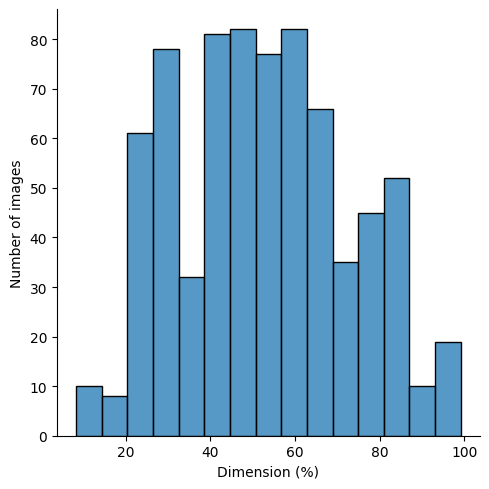

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.displot(df["dimension"])
plt.xlabel("Dimension (%)")
plt.ylabel("Number of images")
plt.show()